In [1]:
import sys
sys.path.append('..')
from somegrad import Tensor
import somegrad.functional as F
from somegrad.nn import Linear, BatchNorm1d, Tanh
from somegrad.optim import SGD

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
def build_dataset(words, block_size):
    xs, ys = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)

            context = context[1:] + [ix] # crop and append
    
    xs = Tensor(xs) 
    ys = Tensor(ys)
    return xs, ys

random.seed(42)
random.shuffle(words)

n = len(words)
n1 = int(0.8 * n)
n2 = int(0.9 * n)

train_words = words[:n1]      # 80%
dev_words   = words[n1:n2]    # 10%
test_words  = words[n2:]      # 10%

print(f"Split sizes: Train: {len(train_words)}, Dev: {len(dev_words)}, Test: {len(test_words)}")

block_size = 3

# create datasets
Xtr, Ytr   = build_dataset(train_words, block_size)
Xdev, Ydev = build_dataset(dev_words, block_size)
Xte, Yte   = build_dataset(test_words, block_size)

Split sizes: Train: 25626, Dev: 3203, Test: 3204


In [6]:
np.random.seed(42)

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = Tensor(np.random.randn(27, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, 27, bias=False), BatchNorm1d(27),
]

# last layer: make less confident
layers[-1].gamma *= 0.1

# all other layers: apply gain
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.data.size for p in parameters)) # number of parameters in total

47024


In [7]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []
ud = []

optimizer = SGD(parameters, lr=0.1)

for layer in layers:
    layer.training = True

for i in range(max_steps):

    # minibatch construct
    ix = np.random.randint(0, Xtr.data.shape[0], (32,))
    Xb, Yb = Xtr.data[ix], Ytr.data[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.reshape(-1, block_size * n_embd) # reshape the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.data.item():.4f}')
    lossi.append(loss.log().data.item())
    ud.append([((optimizer.lr*p.grad).std() / p.std()).log().data.item() for p in parameters])

    #if i >= 1000:
    #    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 100000: 3.2973
  10000/ 100000: 2.2729
  20000/ 100000: 1.9659
  30000/ 100000: 1.7366
  40000/ 100000: 2.0276
  50000/ 100000: 2.3885
  60000/ 100000: 2.3726
  70000/ 100000: 2.6245
  80000/ 100000: 2.2732
  90000/ 100000: 2.3937


layer 2 (      Tanh): mean -0.02, std 0.71, saturated: 15.72%
layer 5 (      Tanh): mean +0.01, std 0.74, saturated: 16.66%
layer 8 (      Tanh): mean +0.01, std 0.76, saturated: 17.88%
layer 11 (      Tanh): mean +0.00, std 0.78, saturated: 17.22%
layer 14 (      Tanh): mean +0.03, std 0.78, saturated: 20.31%


Text(0.5, 1.0, 'activation distribution')

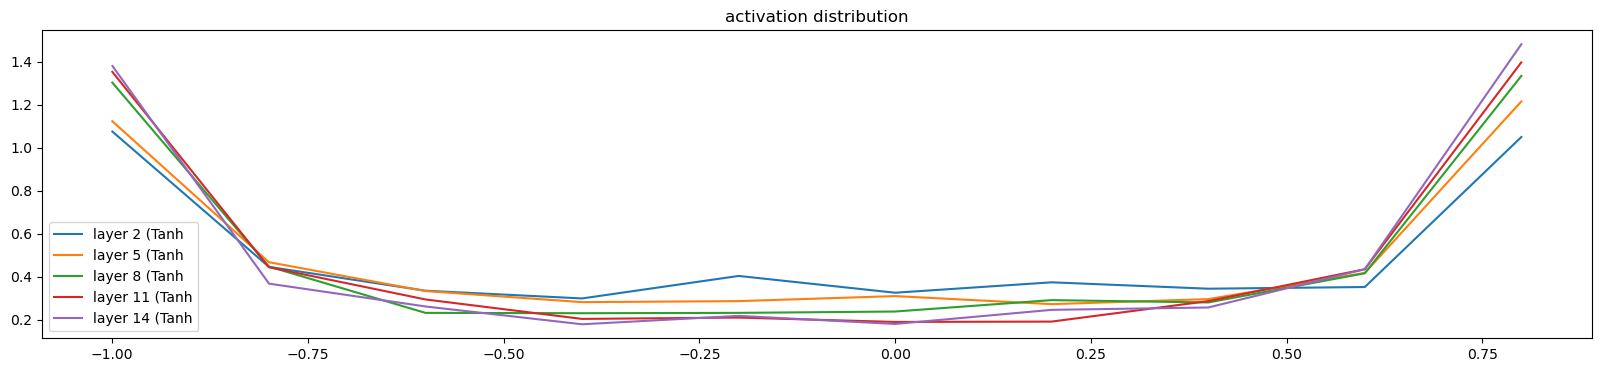

In [8]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.data
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (abs(t) > 0.97).mean()*100))
    hy, hx = F.histogram(t, density=True)
    plt.plot(hx[:-1].data, hy.data)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.755152e-03
layer 5 (      Tanh): mean -0.000000, std 3.296192e-03
layer 8 (      Tanh): mean +0.000000, std 3.432231e-03
layer 11 (      Tanh): mean -0.000000, std 3.381074e-03
layer 14 (      Tanh): mean +0.000000, std 3.485630e-03


Text(0.5, 1.0, 'gradient distribution')

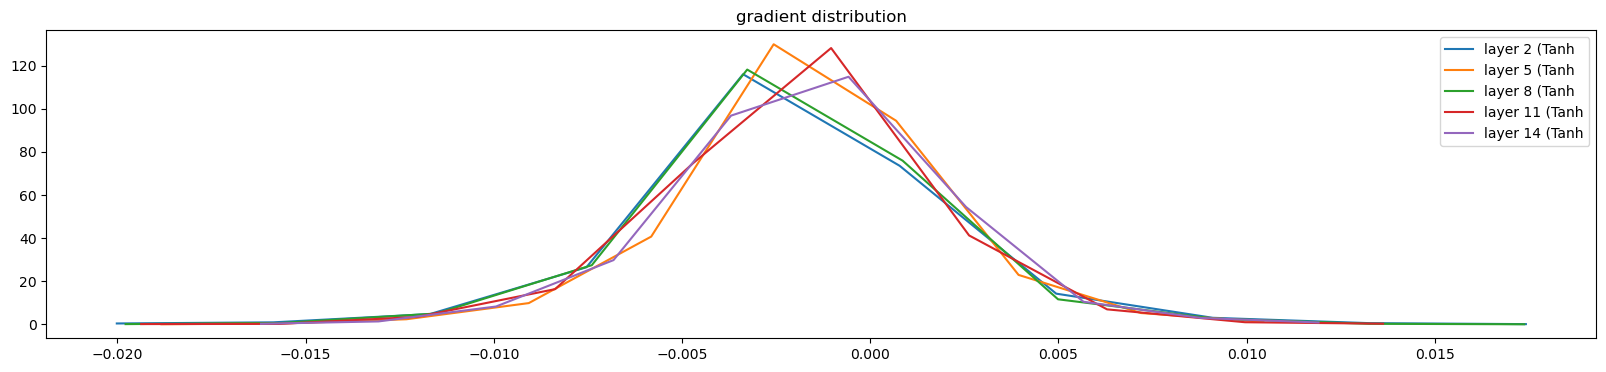

In [9]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = F.histogram(t, density=True)
    plt.plot(hx[:-1].data, hy.data)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.284411e-02 | grad:data ratio 1.189742e-02
weight  (30, 100) | mean +0.000028 | std 8.441824e-03 | grad:data ratio 2.397475e-02
weight (100, 100) | mean -0.000045 | std 5.395319e-03 | grad:data ratio 2.539058e-02
weight (100, 100) | mean -0.000033 | std 5.311852e-03 | grad:data ratio 2.543688e-02
weight (100, 100) | mean +0.000046 | std 5.589216e-03 | grad:data ratio 2.770829e-02
weight (100, 100) | mean +0.000065 | std 5.401843e-03 | grad:data ratio 2.847714e-02
weight  (100, 27) | mean +0.000141 | std 9.108359e-03 | grad:data ratio 2.961998e-02


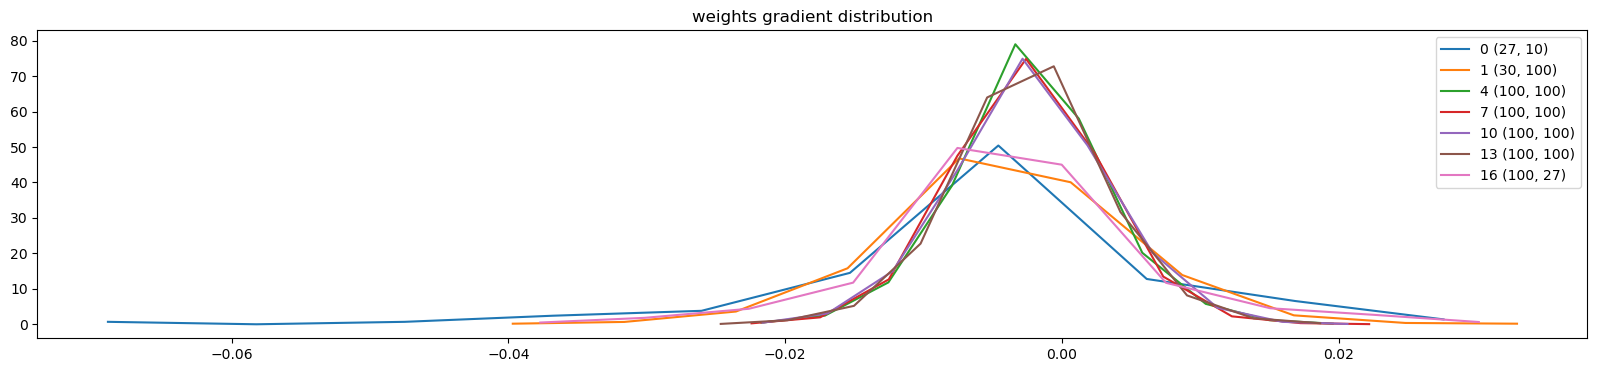

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.data.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.data.shape), t.mean(), t.std(), t.std() / p.data.std()))
    hy, hx = F.histogram(t, density=True)
    plt.plot(hx[:-1].data, hy.data)
    legends.append(f'{i} {tuple(p.data.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

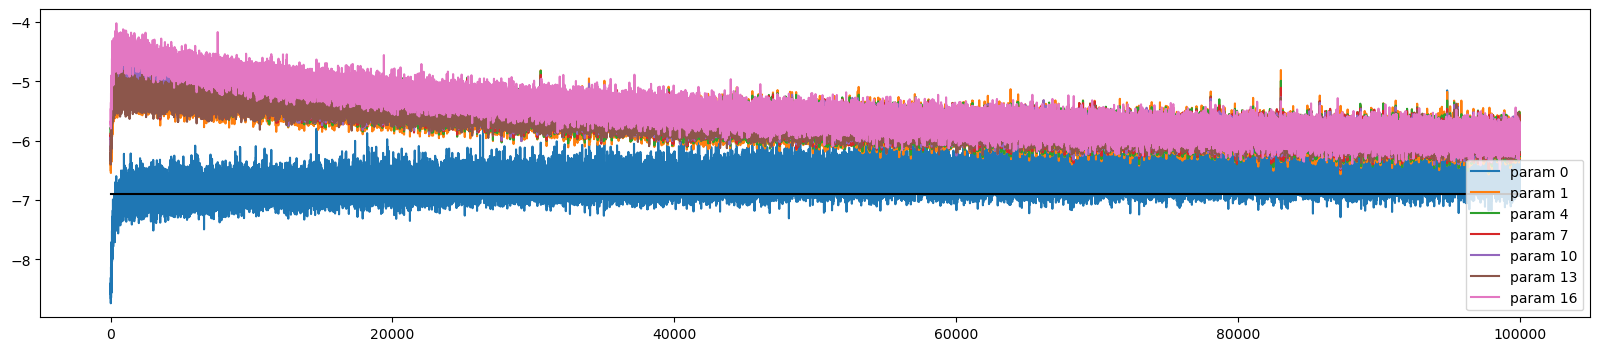

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.data.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-6.9, -6.9], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [12]:
def split_loss(split):        
    x,y = {
        'train': (Xtr.data, Ytr.data),
        'val': (Xdev.data, Ydev.data),
        'test': (Xte.data, Yte.data),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.reshape(emb.data.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.data.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 2.054000425938298
val 2.1131650641769717
test 2.1098899426667233


In [13]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        input_idx = np.array([context]) 
        emb = C[input_idx] # (1, block_size, n_embd)
        x = emb.reshape(emb.data.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x

        # softmax
        counts = logits.exp()
        probs = counts / counts.sum(axis=1, keepdims=True)

        # sampling
        p = probs.data[0]
        p = p / p.sum() 
        
        ix = np.random.choice(len(p), p=p)
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

alrichar.
damarieldasyn.
hutton.
mechuaamy.
man.
damry.
alexani.
romerleen.
kyl.
adricqo.
sky.
ziel.
grettus.
kella.
rylyn.
syson.
yuennynnlee.
zalee.
aoriely.
ken.
